# Урок 4. CNN Свертки

- Обучите CNN (самописная) на CIFAR-100.
- Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.


In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test
    
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 480)
        self.fc2 = torch.nn.Linear(480, 240)
        self.out = torch.nn.Linear(240, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(120, 240, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=960, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=240, bias=True)
  (out): Linear(in_features=240, out_features=100, bias=True)
)


Files already downloaded and verified


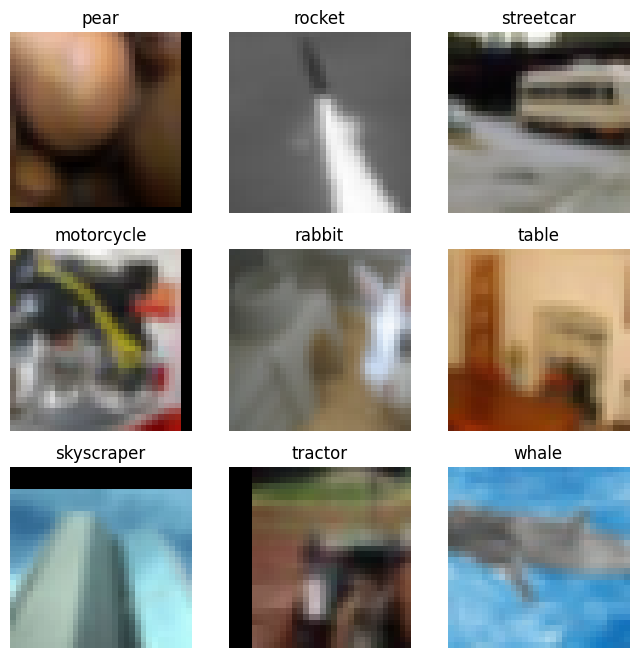

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
i = 1
for img, data in train_loader:
    figure.add_subplot(rows, cols, i)
    plt.title( classes[data[0]] )
    plt.axis("off")
    plt.imshow( img[0].permute(1, 2, 0) )
    i += 1
    if i>9:
        break
plt.show()

## Обучите CNN (самописная) на CIFAR-100.

In [3]:
num_epochs = 5
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train_eval_model(net, num_epochs, train_loader, valid_loader):
    for epoch in range(num_epochs):  
        net.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # обнуляем градиент
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        net.eval()
        test_running_right, test_running_total = 0.0, 0.0
        for i, data in enumerate(valid_loader):
        
            test_outputs = net(data[0].to(device))
            test_running_total += len(data[1])
            test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
        
        print(f'Эпоха {epoch+1} точность предсказаний на валидационной выборке: {round(float(test_running_right/test_running_total), 3)}')

train_eval_model(net, num_epochs, train_loader, valid_loader)
print('Training is finished!')

Эпоха 1 точность предсказаний на валидационной выборке: 0.009
Эпоха 2 точность предсказаний на валидационной выборке: 0.011
Эпоха 3 точность предсказаний на валидационной выборке: 0.011
Эпоха 4 точность предсказаний на валидационной выборке: 0.006
Эпоха 5 точность предсказаний на валидационной выборке: 0.01
Training is finished!


## Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [5]:
# делаем все веса модели не обучаемыми
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

# только последний слой сети будет обучаемым
resnet50.fc = nn.Linear(2048, 100)
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [6]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=0)

params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
net = resnet50
train_eval_model(net, num_epochs, train_loader, valid_loader)


Эпоха 1 точность предсказаний на валидационной выборке: 0.52
Эпоха 2 точность предсказаний на валидационной выборке: 0.558
Эпоха 3 точность предсказаний на валидационной выборке: 0.564
Эпоха 4 точность предсказаний на валидационной выборке: 0.572
Эпоха 5 точность предсказаний на валидационной выборке: 0.562
